In [1]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from scipy import stats
from sklearn.metrics import r2_score

# Read PAP data

In [2]:
# read data
# backfill is a conservative way to gap fill missing values
df = pd.read_excel('micafungin_PAPdata_final.xlsx', index_col=0, skiprows=[0,1,2,4]).fillna(method='backfill')

# limit to MSK strains
msk_strains = list(set(pd.read_csv('../MSK_HCT_isolates/sample_name_dict_MSK_isolates.csv')['Strain'])-set([2160]))
assert len(msk_strains)==118
df = df[msk_strains]

df

,1,2,5,1286,520,2057,522,264,265,17,...,1762,485,489,1258,490,1004,1015,247,249,250
Strain#,,,,,,,,,,,,,,,,,,,,,
0,100.00,100.000,100.000,100.0000,100.00000,100.0000,100.0000,100.00000,100.0000,100.00000,...,100.0000,100.0000,100.000,100.0000,100.0000,100.00,100.0000,100.0000,100.0000,100.0000
1,6.00,3.750,4.286,0.0001,0.07778,0.1250,0.1500,0.08571,0.0001,0.10000,...,0.8333,0.1167,5.000,0.0001,0.2381,2.50,3.3333,0.0025,0.0020,0.0001
2,0.50,0.250,0.043,0.0001,0.06667,0.1250,0.1250,0.02857,0.0001,0.03846,...,0.1333,0.0750,0.100,0.0001,0.0029,0.50,0.0667,0.0001,0.0020,0.0001
4,1.00,0.125,0.100,0.0001,0.02222,0.0875,0.0225,0.04286,0.0001,0.03846,...,0.0833,0.0250,0.350,0.0001,0.0014,0.07,0.0533,0.0001,0.0001,0.0001
8,1.50,0.250,0.143,0.0001,0.03333,0.0625,0.0250,0.01143,0.0001,0.00538,...,0.0667,0.0167,0.200,0.0001,0.0024,0.05,0.0333,0.0001,0.0001,0.0001
16,0.50,0.125,0.143,0.0001,0.02222,0.0125,0.0075,0.01857,0.0001,0.00692,...,0.0500,0.0167,0.060,0.0001,0.0010,0.04,0.0667,0.0001,0.0001,0.0001
32,0.35,0.025,0.029,0.0001,0.01000,0.0375,0.0050,0.00857,0.0001,0.00385,...,0.0050,0.0142,0.015,0.0001,0.0002,0.01,0.0200,0.0001,0.0001,0.0001


# Plot survival curves

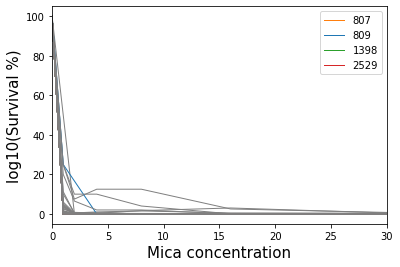

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

strains_to_highlight = [809,807,1398,2529]
colors = list(sns.color_palette())[0:len(strains_to_highlight)]
for strain in df.columns:
    if strain in strains_to_highlight:
        ax.plot(df.index, df[strain], linewidth=1, color=colors[strains_to_highlight.index(strain)], label=strain)
    else:
        ax.plot(df.index, df[strain], linewidth=1, color='Gray')
    
ax.legend()
ax.set_xlabel('Mica concentration', fontsize=15)
#ax.set_yticks([0,1,2,3,4,5,6])
#ax.set_yticklabels([-4,-3,-2,-1,0,1,2])
ax.set_ylabel('log10(Survival %)', fontsize=15)
_ = ax.set_xlim([0,30])

plt.rcParams['svg.fonttype'] = 'none'

# Run NMF

In [15]:
df_T = df.T
model = NMF(n_components=2, init='nndsvda', random_state=42, max_iter=100000, tol=1e-10)
df_W = pd.DataFrame(model.fit_transform(df_T.values), columns=['Factor1','Factor2'], index=df_T.index)
df_W.index.name = 'Strain'
df_H = pd.DataFrame(model.components_, columns=[0,1,2,4,8,16,32], index=['Basis1','Basis2'])

# normalize df_H
multiplier = [100/v for v in list(df_H[0])]
df_H.iloc[0,:] = df_H.iloc[0,:]*multiplier[0]
df_H.iloc[1,:] = df_H.iloc[1,:]*multiplier[1]
df_W.iloc[:,0] = df_W.iloc[:,0]/multiplier[0]
df_W.iloc[:,1] = df_W.iloc[:,1]/multiplier[1]

In [16]:
# test if all values in df_W is non-negative
(df_W>=0).eq(True).all()

Factor1    True
Factor2    True
dtype: bool

# Show basic modes

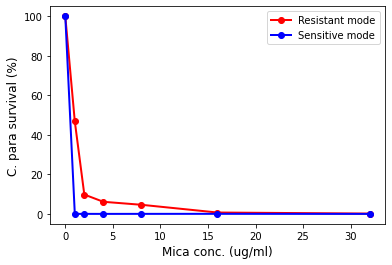

In [17]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharex=True, sharey=True)
_ = ax.plot(df.index, df_H.loc['Basis1',:], 'ro-', linewidth=2, label='Resistant mode')
_ = ax.plot(df.index, df_H.loc['Basis2',:], 'bo-', linewidth=2, label='Sensitive mode')
_ = ax.legend()
_ = ax.set_xlabel('Mica conc. (ug/ml)', fontsize=12)
_ = ax.set_ylabel('C. para survival (%)', fontsize=12)

# Dimensionality reduction

R-squared: 1.000000


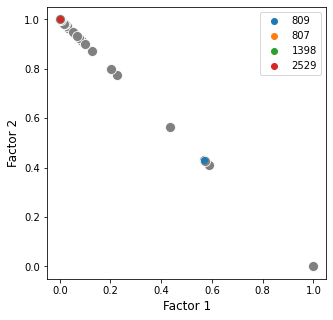

In [18]:
res = stats.linregress(df_W['Factor1'],df_W['Factor2'])
print(f"R-squared: {res.rvalue**2:.6f}")

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
_ = sns.scatterplot(x='Factor1', y='Factor2', data=df_W, color='gray', marker='o', s=100, ax=ax)
xdata = np.linspace(-1,3,100)
ydata = res.intercept + res.slope*xdata

strains_to_highlight = [809,807,1398,2529]
colors = list(sns.color_palette())[0:len(strains_to_highlight)]
for s,c in zip(strains_to_highlight, colors):
    _ = ax.plot(df_W.loc[s,'Factor1'], df_W.loc[s,'Factor2'], 'o', color=c, label=s)
#_ = ax.plot(xdata, ydata, 'k--')
_ = ax.set_xlabel('Factor 1', fontsize=12)
_ = ax.set_ylabel('Factor 2', fontsize=12)
#_ = ax.set_xlim([-0.1,1.1])
#_ = ax.set_ylim([-0.1,1.1])
_ = ax.legend()

# Show reconstruction error

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


R-squared: 0.49


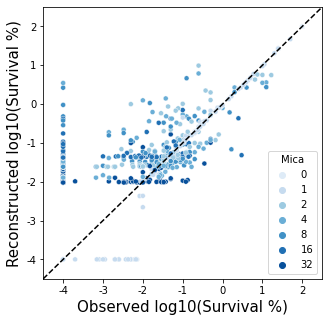

In [47]:
lines = []
mica = [0,1,2,4,8,16,32]
for strain in df.columns:
    obs = df[strain]
    pred = df_W.loc[strain,'Factor1']*df_H.loc['Basis1',:]+df_W.loc[strain,'Factor2']*df_H.loc['Basis2',:]
    for conc, yobs, ypred in zip(mica, obs, pred):
        lines.append([strain, conc, np.log10(yobs)+4, np.log10(ypred)+4])
df_reconst = pd.DataFrame(lines, columns=['Strain','Mica','Yobs','Ypred'])
df_reconst['Mica'] = df_reconst['Mica'].astype(str)
df_reconst = df_reconst.fillna(0).replace(-np.inf, 0)

fig,ax = plt.subplots(figsize=(5, 5))
_ = sns.scatterplot(x='Yobs', y='Ypred', hue='Mica', palette='Blues', ax=ax, data=df_reconst, s=25)
ax.set_xlim([-0.5,6.5])
ax.set_ylim([-0.5,6.5])
ax.plot([-0.5,6.5],[-0.5,6.5],'k--')
ax.set_xlabel('Observed log10(Survival %)', fontsize=15)
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels([-4,-3,-2,-1,0,1,2])
ax.set_ylabel('Reconstructed log10(Survival %)', fontsize=15)
ax.set_yticks([0,1,2,3,4,5,6])
ax.set_yticklabels([-4,-3,-2,-1,0,1,2])

r2 = r2_score(y_true=df_reconst['Yobs'], y_pred=df_reconst['Ypred'])
print("R-squared: %2.2f"%(r2))
